<a href="https://colab.research.google.com/github/naraB/handson-ml-notes/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

In [0]:
import numpy as np

## Downloading the dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure: 

* *DESCR* key describing the dataset
* *data* key containing an array with one row per instance and one column per feature
* *target* key containing an array with labels

In [3]:
X,y = mnist['data'], mnist['target']
print('X shape', X.shape)
print('y shape', y.shape)

X shape (70000, 784)
y shape (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 * 28 pixels, and each feature simply represents one pixel's instensity, from 0 (white) to 255 (black). Lets take apeek at one digit from the dataset. All we need to do is grab an instance's feature vector, reshapre it to a 28 * 28 array, and display it using Matplotlib's imhsow() function:

(784,)


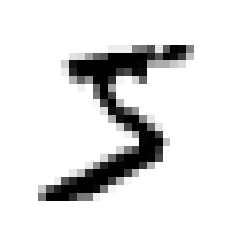

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
print(some_digit.shape)
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [0]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so lets cast y to integer:

In [0]:
y = y.astype(np.uint8)

## Creating test and train set

The MNIST dataset is already split into a training set (the first 60,000 images) and test set (the last 10,000 images)

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training data is already shuffled for us

## Binary Classification

Let's simplify the problem for now and only tr to identify one digit - for example, te number 5. This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5

In [0]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### Training

Let's use a *Stochastic Gradient Descent* (SGD) classifier, Scikit-learn's SGDClassifier class.

The classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now we can use it to detect images of the number 5:

In [0]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available.

#### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation

In [0]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others)

#### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, we first need to have a set of predictions so that they can be compared to the actual targets.

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [0]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by a model that never saw the data during training)

cross_val_predict() splits the data into K parts (as does cross_val_score()) and then for i=1...k iterations: 

* takes the i-th part as test data and all other parts as training data

* trains the model with training data (all parts except i-th part)

* then by using this trained model, predicts labels for i-th part (test data)

In each iteration, label of i-th part of the data gets predicted. In the end cross_val_prediction concatenates all partially predicted labels and returns them as the final result.


In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (*negative class*): 53,892 of them were correctly classified as non-5s (they are called *true negatives*), while the remaining 687 were wrongly classified as 5s (*false positives*). The second row considers the images of 5s (*positive class*): 1,891 were wrongly classified as non-5s (*false negatives*), while the ramaining 3,530 were correctly classified as 5s (*true positives*). 

To recap:

* *negative class*: first row (non-5 images)
* *postive class*: second row (images of 5s)
* *true negatives*: correctly classified as non 5's (52,892)
* *true postives*: correctly classified as 5's (3,530)
* *false postives*: wrongly classified as 5's (687)
* *false negatives*: wrongly classified as non 5's (1,891)




A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal

In [0]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### Precision and Recall

**Precision = the accuracy of the positive predictions; the precision of the classifier**

* precision = TP / (TP + FP)

* TP = number of true positives
* FP = number of false positives

* What is the ratio of correctly classified 5's and wrongly classified 5's (false positives) + correctly classified 5's

* What percentage are the actual correctly predicted 5's out of all predicted 5's

* How precise was my positive predictions

***Recall* (also *sensitivity* or the *true positive rate*) = the ratio of positives instances that are correctly detected by the classifier**

* recall = TP / (TP + FN)

* FN = false negatives

* What is the ratio of correctly classified 5's and missed 5's (wrongly classified non-5's) + correctly classified 5's

* Ratio of how many out of all of the positive class we classified correctly

* How many actual positives did I miss?

In [0]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [0]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Precision
* Wrongly classified approx. 17% non 5's as 5's
* When it claims an image represents a 5, it's correct 83% of the time


Recall
* Wrongly classified approx 35% as non 5's even though they were 5's
* Detects 65% of all of the 5's


##### F1 Score

F1 score = combines precision and recall into a single metric and is a simple way to compare two classifiers

The F1 score is the harmonic mean of precision and recall. Whereas the regular mean trats all values equally, the harmonic mean gives much more weight to low values. As aresult, the classifier will only get a high F1 score if both recall and precision are high.

F1 = 2 * (precision * recall) / (precision + recall)

In [0]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similiar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall

Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall trade-off*

##### Precision/Recall Trade-off

To understand this trade-off, let's look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. Conversly, lowering the threshold increases recall and reduces precision

Scikit-Learn does not let you set the threshold directly, but it does gives you access to the decision scores that it uses to make predictions. Instead of calling the classifier's predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions base on those scores:


In [0]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [0]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

How do you decide which threshold to use? 
* First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds:

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value:

In [0]:
# highlight the threshold and add the legend, axis label, and grid
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend(loc="lower right")

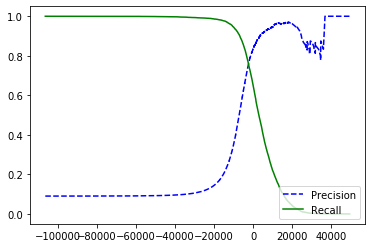

In [0]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

In [0]:
thresholds_90_precision = thresholds[np.argmax(precisions >= 0.90)]
thresholds_90_precision

3370.0194991439557

In [0]:
y_train_pred_90 = (y_scores >= thresholds_90_precision)

In [0]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [0]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

##### The ROC Curve

***ROC* (reciever operating characteristic) curve plots the *true positive rate* (another name for recall) against the *false positive rate* (FPR).**

* The FPR (false positive rate) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the *true negative rate* (TNR)

* The TNR (true negative rate) is the ratio of negative instances that are correctly classified as negative. It is also called specificy. Hence, the ROC curve plots recall versus 1 - specificy

In [0]:
conf_matr = confusion_matrix(y_train_5, y_train_pred)
fpr = conf_matr[0][1] / (conf_matr[0][0] + conf_matr[0][1]) # false positives / negatives
tnr = conf_matr[0][0] / (conf_matr[0][0] + conf_matr[0][1])
print('fpr', fpr)
print('tnr', tnr)
print('1 - tnr', 1-tnr)


fpr 0.012587258835815972
tnr 0.987412741164184
1 - tnr 0.012587258835816018


In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier moves toward the top-left corner ad stays as far away from that line as possible

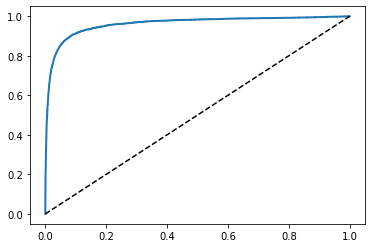

In [0]:
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Rule of thumb:

* Prefer the precision/recall curve whenever the positive class is rare or when you care more about the false positives than the false negatives.

* Otherwise, use the ROC curve

Looking at the previous ROC curve and the ROC AUC score, you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner)

#### RandomForestClassifier vs SGDClassifier

RandomForestClassifier class does not have a decision_function() method. Instead, it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other, or both. the predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [0]:
# Let's train a RFC and compare its ROC and ROC AUC to a SGDClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

The roc_curve() function expects labels and scores, but instead of scores you can give it class probabilities. Let's use the positive class's probability as the score:

In [0]:
y_score_forest = y_probas_forest[:, 1] # probabilities of images being 5's (proba of positive class)
print('RFC predicted cross validation probabilities of being 5\'s', y_score_forest)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)

RFC predicted cross validation labels [0.89 0.01 0.04 ... 0.98 0.08 0.06]


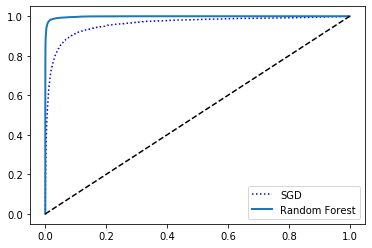

In [0]:
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

As we can see, the RandomForestClassifier's ROC curve looks much better than the SGDClassifier's: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [0]:
roc_auc_score(y_train_5, y_score_forest)

0.9983436731328145

Let's look at the precision and recall of the RandomForestClassifier

In [0]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score_forest)

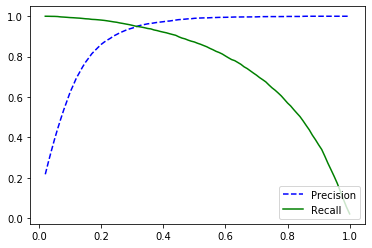

In [0]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [0]:
y_true = (y_score_forest >= 0.5)
y_true

array([ True, False, False, ...,  True, False, False])

In [0]:
precision_score(y_train_5, y_true)

0.9897468089558485

In [0]:
recall_score(y_train_5, y_true)

0.8725327430363402

## Multiclass Classification


**Can distinguish between more than two classes**

SGD, Random Forest and naive Bayes classifiers are capable of handling multiple classes natively.

Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary.
However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

* *One-versus-the-rest* (OvR) strategy (also called *one-versus-all*): 
  * Train N binary classifiers, one for each class. Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score

* *One-versus-one* (OvO) strategy: 
  * Train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, and so on. If there are N classes, you need to train N x (N-1) / 2 classifiers. When you want to classify an image, you have to run the image through all 45 classifiers and see which one wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes it must distinguish

Some algorithms (such as SVM classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on a small training set than to train a few classifiers on a large training set. For most binary classification algorithms, however, OvR is preffered

### Binary Classifiers for Multiclass Classification

Scitkit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let's try this with a SVM classifier:

In [0]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

If you call the decision_function() method, you will see that it return 10 scores per instance (instead of just 1). That's one score per class:

In [0]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The highest score is indeed the one corresponding to class 5:

In [0]:
np.argmax(some_digit_scores)

5

When a classifier is trained, it sores the list of target classes in its classes_ attribute, order by value. In this case, the index of each class in the classes_ array conveniently matches the class itself, but in general that's not happening

In [0]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

If you want to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes.

Let's use the OvR strategy:

In [0]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [0]:
print("SVM CLF OvR estimators num", len(ovr_clf.estimators_))

SVM CLF OvR estimators num 10


### Multiclass Classifiers

Let's look at how the SGD Classifier performs

In [16]:
from sklearn.model_selection import cross_val_score

sgd_clf.fit(X_train, y_train)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 8% on all test folds.

Let's scale the inputs and try again:

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

Let's analyze the types of errors the SGD Classifier makes

* First, look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function.

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Let's plot it using Matplotlib's matshow() funtion:

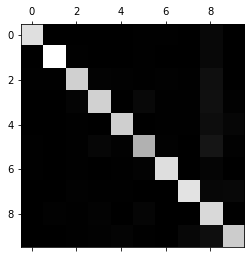

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digit, which could mean that:

* there are fewer images of 5s in the dataset or

* the classifier does not perform as well on 5s as on other digits.

We can verify that both are the case

Let's focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result:

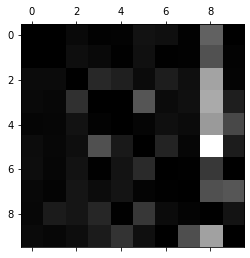

In [22]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can clearly see the kinds of errors the classifier makes. The rows represent actual classes, while column represent predicted classes. The column for class 8 is quite bright, which tells us that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s ad 5s often get confused (in both direction)

Analyzing the confusion matrix often gives insights into ways to improve classifiers. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing but it is more difficult and time-consuming

## Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. 

In [25]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # Translates slice objects to concatenation along the second axis.



knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [28]:
knn_clf.predict([some_digit])

array([[False,  True]])

The digit 5 is indeed not large (False) and odd (True).

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric dicussed earlier), then simply compute the average score. This code computes the average F1 score across all labels:

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [30]:
from sklearn.metrics import f1_score

f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, however, which may not be the case. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code

## Multioutput Classification

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values)

To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system

The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification.

In [0]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's take a look

In [0]:
def plot_digit(digit):
  digit_image = digit.reshape(28, 28)
  plt.imshow(digit_image, cmap="binary")
  plt.axis("off")
  plt.show()

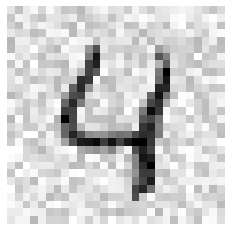

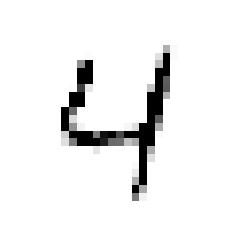

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[4]])
plot_digit(X_test_mod[4])
plot_digit(clean_digit)